STRATEGY 2 : TREND BASED

HERE IS THE CODE FOR BANK NIFTY FOR 15 MIN TIMEFRAME

In [36]:
import pandas as pd
import numpy as np

In [37]:
# LOAD AND PREPARE OF DATA
df = pd.read_csv('datasets/NB_15.csv')
df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"])
df = df.sort_values("datetime").reset_index(drop=True)
df.head()

,date,time,open,high,low,close,volume,datetime
0,2020-01-01,09:15:00,32237.90,32338.55,32229.95,32336.85,0,2020-01-01 09:15:00
1,2020-01-01,09:30:00,32336.65,32347.50,32239.30,32247.35,0,2020-01-01 09:30:00
2,2020-01-01,09:45:00,32247.55,32251.80,32174.05,32206.00,0,2020-01-01 09:45:00
3,2020-01-01,10:00:00,32204.20,32207.55,32132.30,32139.20,0,2020-01-01 10:00:00
4,2020-01-01,10:15:00,32142.55,32188.05,32133.55,32171.10,0,2020-01-01 10:15:00


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31636 entries, 0 to 31635
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      31636 non-null  object        
 1   time      31636 non-null  object        
 2   open      31636 non-null  float64       
 3   high      31636 non-null  float64       
 4   low       31636 non-null  float64       
 5   close     31636 non-null  float64       
 6   volume    31636 non-null  int64         
 7   datetime  31636 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 1.9+ MB


In [39]:
# CALCULATING TRADITIONAL RENKO
brick_size = 10
renko = [df['close'][0]]
for i in range(1, len(df)):
    price_diff = df['close'][i] - renko[-1]
    if abs(price_diff) >= brick_size:
        brick_count = int(price_diff / brick_size)
        renko.extend([renko[-1] + brick_count * brick_size] * abs(brick_count))

df['renko'] = renko[:len(df)]

CALCULATING INDICATORS

In [40]:
# EMA Indicator
df["EMA_20"] = df["renko"].ewm(span=20, adjust=False).mean()
df["EMA_50"] = df["renko"].ewm(span=50, adjust=False).mean()

from ta.momentum import RSIIndicator 

# RSI Calculation (using 14-period RSI)
rsi_indicator = RSIIndicator(close=df['renko'], window=14)
df['rsi'] = rsi_indicator.rsi()

In [41]:
# TRADING PARAMETERS
target = 400
stoploss = 50
slippage_pct = 0.0001  # 0.01% slippage
position = None
entry_price = 0
entry_time = None
trades = []
lot_size = 30

In [42]:
# BACKTESTING THE TRADE

for i in range(len(df)):
    row = df.iloc[i]
    price = row["renko"]

    # Entry: Long condition if EMA_20 > EMA_50 and RSI > 60
    if position is None:
        if row["EMA_20"] > row["EMA_50"] and row["rsi"] > 60:
            position = "long"
            entry_price = price * (1 + slippage_pct)
            entry_time = row["datetime"]
        # Short condition if EMA_20 < EMA_50 and RSI < 40
        elif row["EMA_20"] < row["EMA_50"] and row["rsi"] < 40:
            position = "short"
            entry_price = price * (1 - slippage_pct)
            entry_time = row["datetime"]

    # Exit conditions for long position
    if position == "long":
        if price <= entry_price - stoploss or price >= entry_price + target \
           or not (row["EMA_20"] > row["EMA_50"] ):
            exit_price = price * (1 - slippage_pct)
            trades.append({
                "type": "long",
                "entry_price": entry_price,
                "exit_price": exit_price,
                "entry_time": entry_time,
                "exit_time": row["datetime"]
            })
            position = None

    # Exit conditions for short position
    elif position == "short":
        if price >= entry_price + stoploss or price <= entry_price - target \
           or not (row["EMA_20"] < row["EMA_50"] ):
            exit_price = price * (1 + slippage_pct)
            trades.append({
                "type": "short",
                "entry_price": entry_price,
                "exit_price": exit_price,
                "entry_time": entry_time,
                "exit_time": row["datetime"]
            })
            position = None

# Trade DataFrame
trades_df = pd.DataFrame(trades)


METRICS CALCULATION 

In [43]:
# METRICS CALCULATION
# % Return per trade
trades_df["pnl_pct"] = np.where(
    trades_df["type"] == "long",
    (trades_df["exit_price"] - trades_df["entry_price"]) / trades_df["entry_price"],
    (trades_df["entry_price"] - trades_df["exit_price"]) / trades_df["entry_price"]
)

# Capital Setup
initial_capital = 1_000_000  # ₹10 lakhs
leverage = 5
effective_capital = initial_capital * leverage

# PnL in ₹
trades_df["pnl_amount"] = trades_df["pnl_pct"] * effective_capital
trades_df["equity"] = initial_capital + trades_df["pnl_amount"].cumsum()

# === Performance Metrics ===
total_pnl = trades_df["pnl_amount"].sum()
returns = trades_df["pnl_amount"] / initial_capital
sharpe = (returns.mean() * 252 - 0.06) / (returns.std() * np.sqrt(252)) if returns.std() > 0 else 0

# Max Drawdown
equity = trades_df["equity"]
roll_max = equity.cummax()
drawdown = roll_max - equity
max_dd = drawdown.max()
max_dd_duration = drawdown[drawdown > 0].groupby((drawdown == 0).cumsum()).count().max()

# Calmar Ratio
days = (pd.to_datetime(trades_df["exit_time"]).max() - pd.to_datetime(trades_df["entry_time"]).min()).days or 1
annual_return = (total_pnl / initial_capital) * (365 / days)
calmar = annual_return / (max_dd / initial_capital) if max_dd != 0 else np.nan

# Win Rate & Profit Factor
num_wins = (trades_df["pnl_amount"] > 0).sum()
num_losses = (trades_df["pnl_amount"] <= 0).sum()
win_rate = num_wins / len(trades_df)
profit_factor = trades_df[trades_df["pnl_amount"] > 0]["pnl_amount"].sum() / abs(trades_df[trades_df["pnl_amount"] <= 0]["pnl_amount"].sum()) if num_losses > 0 else np.inf


In [44]:
# METRICS PRINTING
print("=== Strategy Performance (Using Full Capital) ===")
print(f"Initial Capital     : ₹{initial_capital:,.0f}")
print(f"Leverage            : {leverage}x → Effective Capital: ₹{effective_capital:,.0f}")
print(f"Total PnL           : ₹{total_pnl:,.0f}")
print(f"Sharpe Ratio        : {sharpe:.2f}")
print(f"Max Drawdown        : ₹{max_dd:,.0f}")
print(f"Max Drawdown Duration: {max_dd_duration} trades")
print(f"Calmar Ratio        : {calmar:.2f}")
print(f"Win Rate            : {win_rate:.2%}")
print(f"Profit Factor       : {profit_factor:.2f}")

=== Strategy Performance (Using Full Capital) ===
Initial Capital     : ₹1,000,000
Leverage            : 5x → Effective Capital: ₹5,000,000
Total PnL           : ₹6,351,652
Sharpe Ratio        : 1.81
Max Drawdown        : ₹750,243
Max Drawdown Duration: 151 trades
Calmar Ratio        : 1.66
Win Rate            : 31.98%
Profit Factor       : 1.44


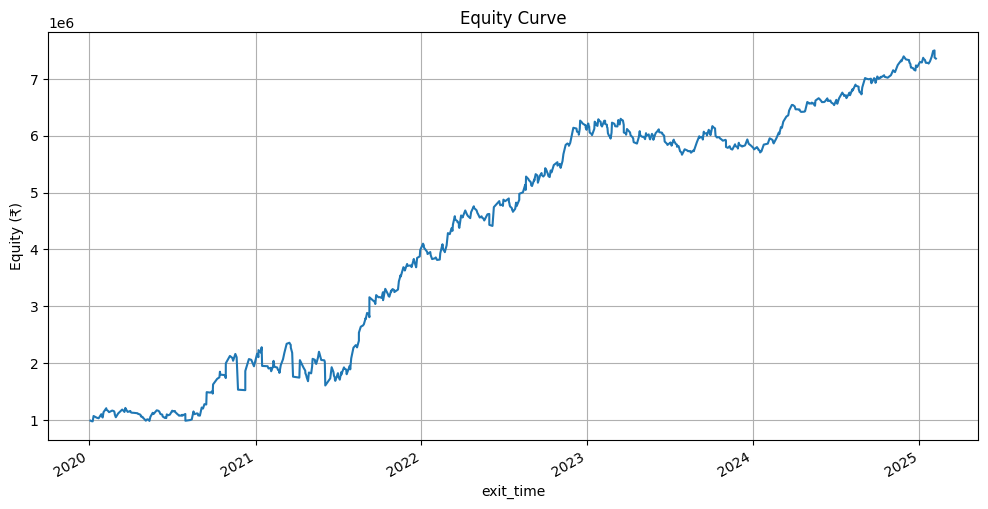

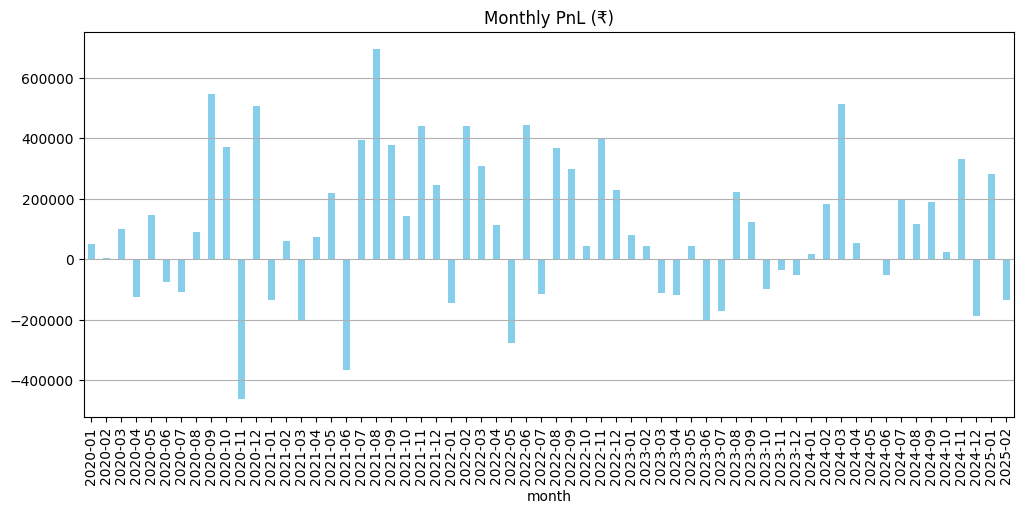

In [45]:
#PLOTTING THE CURVES 

import matplotlib.pyplot as plt

# === Equity Curve Plot ===
trades_df.plot(x="exit_time", y="equity", title="Equity Curve", figsize=(12, 6), legend=False)
plt.ylabel("Equity (₹)")
plt.grid(True)
plt.show()

# === Monthly Returns Plot ===
trades_df["month"] = pd.to_datetime(trades_df["exit_time"]).dt.to_period("M")
monthly_returns = trades_df.groupby("month")["pnl_amount"].sum()
monthly_returns.plot(kind='bar', figsize=(12, 5), color='skyblue', title="Monthly PnL (₹)")
plt.xticks(rotation=90)
plt.grid(True, axis='y')
plt.show()
